In [1]:
import os 
import numpy as np

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import recall_score, f1_score
import re
from sklearn.metrics import confusion_matrix


2024-02-08 21:18:23.347129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 21:18:23.347238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 21:18:23.635410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Importing Data

In [2]:
train_val_data_path = os.path.join("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")
train_data_path = os.path.join(train_val_data_path, "train")
val_data_path = os.path.join(train_val_data_path, "valid")
test_data_path = os.path.join("/kaggle/input/new-plant-diseases-dataset/test/test")


In [3]:
classes = os.listdir(train_data_path)
classes

['Tomato___Late_blight',
 'Tomato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Potato___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Peach___healthy',
 'Apple___Apple_scab',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Bacterial_spot',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Peach___Bacterial_spot',
 'Apple___Cedar_apple_rust',
 'Tomato___Target_Spot',
 'Pepper,_bell___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Late_blight',
 'Tomato___Tomato_mosaic_virus',
 'Strawberry___healthy',
 'Apple___healthy',
 'Grape___Black_rot',
 'Potato___Early_blight',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Common_rust_',
 'Grape___Esca_(Black_Measles)',
 'Raspberry___healthy'

In [4]:
def show_random_smample(data_path, n_samples):
    classes = os.listdir(data_path)
    fig, ax = plt.subplots(1, n_samples, figsize=(5*n_samples, 6))
    fig.figure.figsize=(5*n_samples, 5)
    for i in range(n_samples):
        rand_class = classes[np.random.randint(0, len(classes), 1)[0]]
        rand_class_path = os.path.join(data_path, rand_class)
        samples = os.listdir(rand_class_path)
        rand_sample = np.random.randint(0, len(samples), 1)[0]
        img = cv2.imread(os.path.join(rand_class_path, samples[rand_sample]), cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].set_title(f"{rand_class},\n {img.shape}")
    fig.tight_layout()
    fig.suptitle("Random samples")
    fig.show()

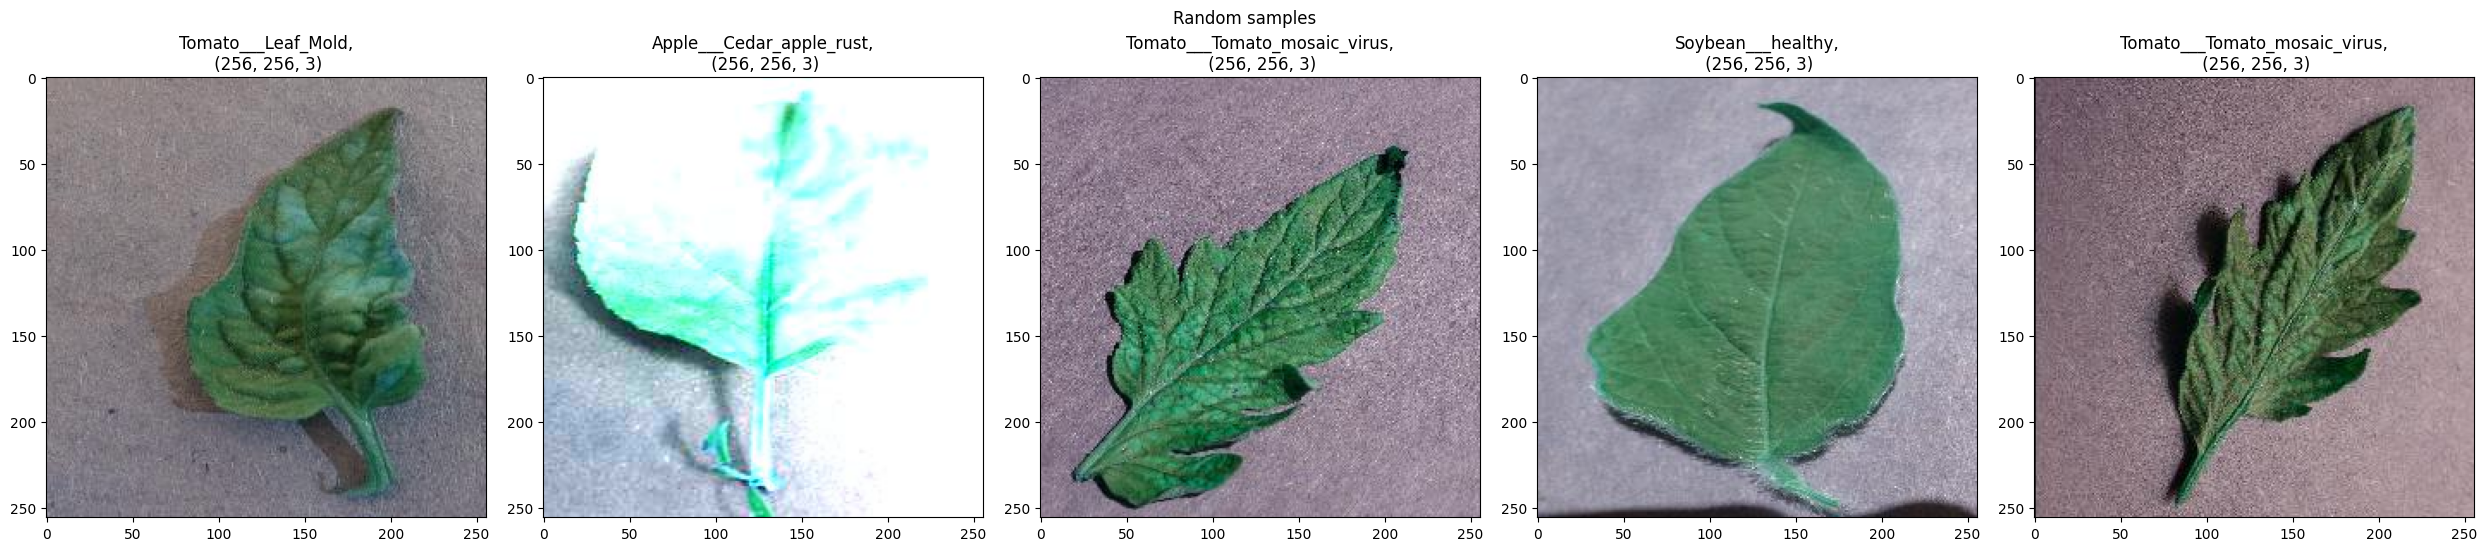

In [5]:
show_random_smample(train_data_path, n_samples=5)

## ImageDataGenerators

In [6]:
img_height, img_width = 256, 256
batch_size = 64

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Flow data from the training directory
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classes,
    class_mode='categorical'  # Set to 'binary' or 'categorical' based on your problem
)

# Create an ImageDataGenerator for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
# Flow data from the validation directory
validation_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = classes,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


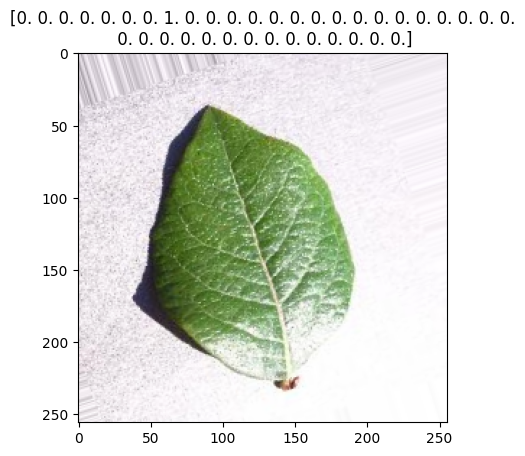

In [7]:
rand_batch = next(iter(train_generator))
plt.imshow(rand_batch[0][0])
plt.title(str(rand_batch[1][1]))
plt.show()

In [8]:
train_generator.class_indices

{'Tomato___Late_blight': 0,
 'Tomato___healthy': 1,
 'Grape___healthy': 2,
 'Orange___Haunglongbing_(Citrus_greening)': 3,
 'Soybean___healthy': 4,
 'Squash___Powdery_mildew': 5,
 'Potato___healthy': 6,
 'Corn_(maize)___Northern_Leaf_Blight': 7,
 'Tomato___Early_blight': 8,
 'Tomato___Septoria_leaf_spot': 9,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 10,
 'Strawberry___Leaf_scorch': 11,
 'Peach___healthy': 12,
 'Apple___Apple_scab': 13,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14,
 'Tomato___Bacterial_spot': 15,
 'Apple___Black_rot': 16,
 'Blueberry___healthy': 17,
 'Cherry_(including_sour)___Powdery_mildew': 18,
 'Peach___Bacterial_spot': 19,
 'Apple___Cedar_apple_rust': 20,
 'Tomato___Target_Spot': 21,
 'Pepper,_bell___healthy': 22,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 23,
 'Potato___Late_blight': 24,
 'Tomato___Tomato_mosaic_virus': 25,
 'Strawberry___healthy': 26,
 'Apple___healthy': 27,
 'Grape___Black_rot': 28,
 'Potato___Early_blight': 29,
 'Cherry_(inclu

In [9]:
plants = set(map(lambda r: r.split('_')[0], classes))
plants

{'Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato'}

## Building the model

In [10]:
mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False)

for layer in mobilenet_v2.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# Add custom layers on top of the base model
x = mobilenet_v2.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(len(classes), activation='softmax')(x)  # Output layer

# Create the final model
model = tf.keras.Model(inputs=mobilenet_v2.input, outputs=predictions)


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']        

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',  # Standard metric
                       tf.keras.metrics.Recall()])

In [14]:
results = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12,
    steps_per_epoch=200,
    verbose=1)

Epoch 1/12


I0000 00:00:1707427213.881481      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 761s 4s/step - loss: 0.7226 - accuracy: 0.7908 - recall: 0.7037 - val_loss: 0.3758 - val_accuracy: 0.8807 - val_recall: 0.8451
Epoch 2/12
200/200 [==============================] - 664s 3s/step - loss: 0.3446 - accuracy: 0.8891 - recall: 0.8616 - val_loss: 0.3272 - val_accuracy: 0.8929 - val_recall: 0.8713
Epoch 3/12
200/200 [==============================] - 627s 3s/step - loss: 0.2938 - accuracy: 0.9038 - recall: 0.8829 - val_loss: 0.2676 - val_accuracy: 0.9125 - val_recall: 0.8936
Epoch 4/12
200/200 [==============================] - 621s 3s/step - loss: 0.2546 - accuracy: 0.9151 - recall: 0.9003 - val_loss: 0.2764 - val_accuracy: 0.9079 - val_recall: 0.8911
Epoch 5/12
200/200 [==============================] - 618s 3s/step - loss: 0.2311 - accuracy: 0.9224 - recall: 0.9099 - val_loss: 0.2299 - val_accuracy: 0.9228 - val_recall: 0.9099
Epoch 6/12
200/200 [==============================] - 612s 3s/step - loss: 0.2129 - accuracy: 0.9295 - rec

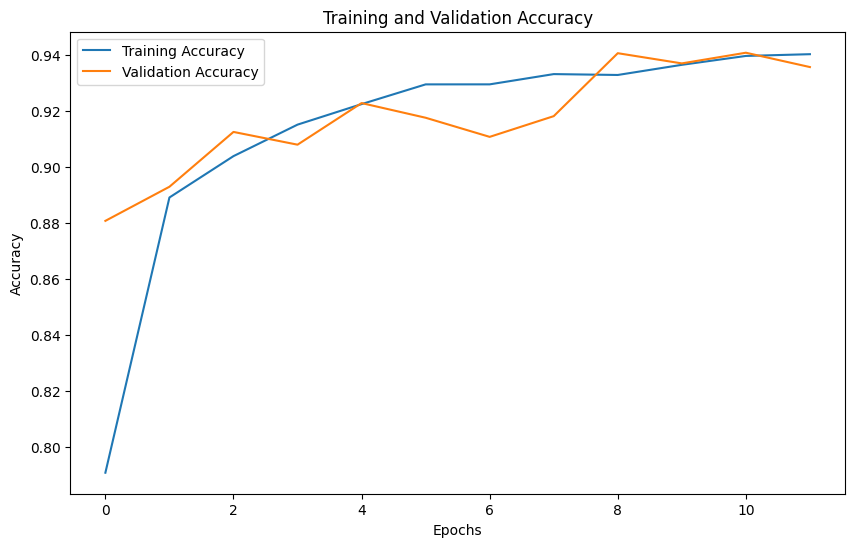

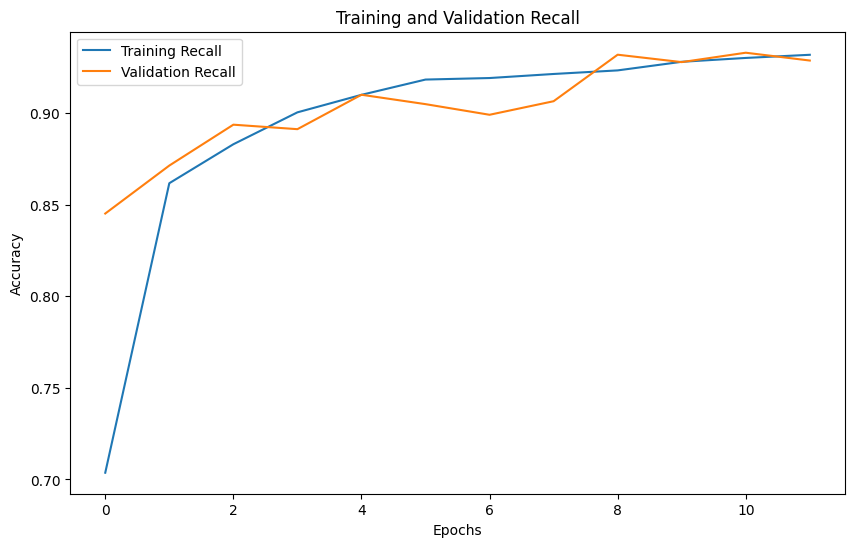

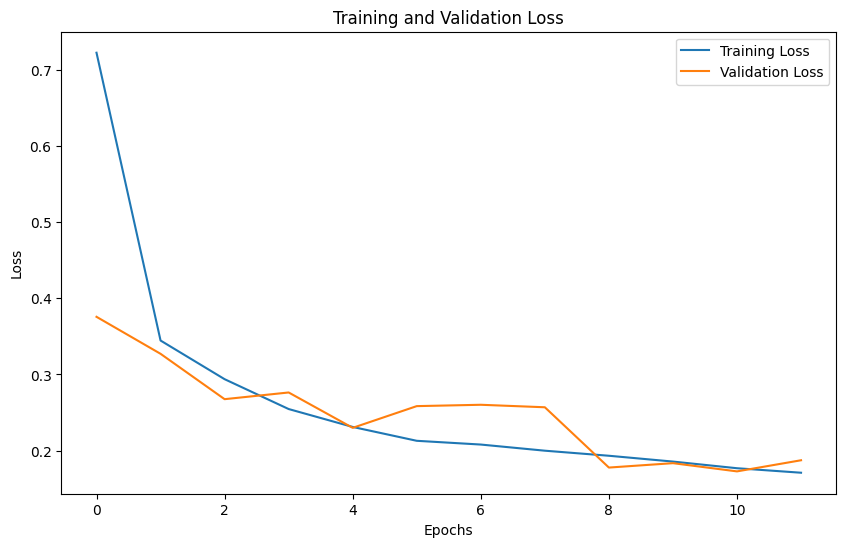

In [15]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation recall
plt.figure(figsize=(10, 6))
plt.plot(results.history['recall'], label='Training Recall')
plt.plot(results.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
# model.save("Planet_Diagnoser.h5")

In [17]:
len(os.listdir(test_data_path))

33

In [18]:
model.evaluate(validation_generator)

275/275 [==============================] - 336s 1s/step - loss: 0.1886 - accuracy: 0.9376 - recall: 0.9303


[0.18855643272399902, 0.9376280307769775, 0.9302868247032166]

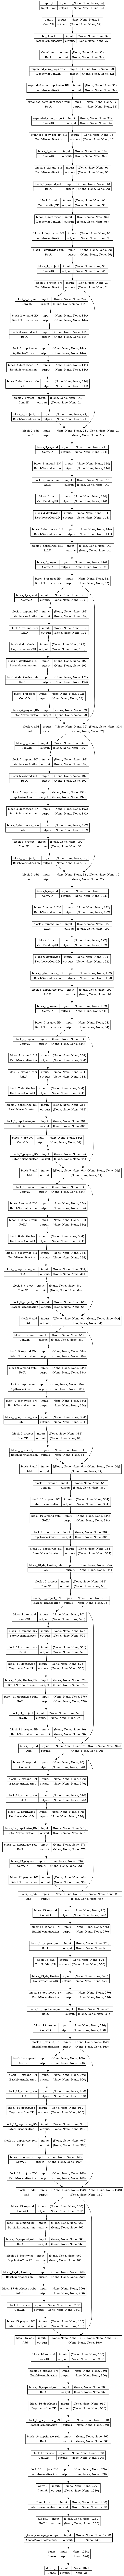

In [19]:
tf.keras.utils.plot_model(model, to_file='model_layers.png', show_shapes=True, show_layer_names=True)
